# Regresión Logística con variables de las diferencias de medias ponderadas

* [Lectura de ficheros](#lectura-de-ficheros)
* [Preparación conjunto entrenamiento y prueba](#preparacion-de-conjuntos-de-entrenamiento-y-prueba)
* [Mapa de calor de correlaciones entre variables](#mapa-de-calor-de-correlaciones-entre-variables)
* [Escalado de variables](#escalado-de-variables)
* [Ajuste de hiperparámetros](#ajuste-de-hiperparametros)
* [Evaluación del modelo](#evaluacion-del-modelo)

### Descripción general del notebook

En este notebook se llevará a cabo el modelado y entrenamiento de un modelo de regresión logística con el propósito de predecir la probabilidad de que un peleador gane una pelea. Para ello, se utilizarán las diferencias en las estadísticas medias de cada peleador como variables predictoras.

El objetivo principal es explorar cómo la regresión logística puede ser una alternativa eficaz y compararla con otros métodos de clasificación para mejorar la precisión en la predicción del ganador.

Dado que el proceso de transformación de datos, selección de variables y ajuste de hiperparámetros será similar al realizado en otros modelos, estos aspectos no serán abordados en detalle en esta ocasión.

In [5]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, log_loss,confusion_matrix,make_scorer,f1_score
import seaborn as sns
from scipy.stats import uniform, loguniform
import mlflow

In [6]:
ruta_mlflow = os.path.abspath(os.path.join("..", "..", "..", "mlruns"))

 # Configurar MLflow para guardar los modelos en esa ruta
mlflow.set_tracking_uri(f"file:///{ruta_mlflow}")

print("MLflow tracking URI:", mlflow.get_tracking_uri())  

MLflow tracking URI: file:///c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\mlruns


In [25]:
mlflow.set_experiment("Prueba con df ponderado P2 usando P2_dif LinearRegressor, datos finales")

<Experiment: artifact_location='file:///c:\\Users\\mattu\\OneDrive\\Documentos\\GitHub\\c2425-R4\\mlruns/952129509267405796', creation_time=1743072694789, experiment_id='952129509267405796', last_update_time=1743072694789, lifecycle_stage='active', name='Prueba con df ponderado P2 usando P2_dif LinearRegressor, datos finales', tags={}>

### Lectura de ficheros

In [8]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..","..", "data", "P2_dif","train.parquet")
df_train= pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2010-01-02,Rashad Evans,Thiago Silva,False,0.04,-0.2808,0.193548,-0.40,0.00,-18.84,...,16.0,4,-8.396724,-1,-0.76,0.00,4.00,-0.24,0.0,1.0
1,2010-01-02,Sam Stout,Joe Lauzon,False,0.36,-0.2228,-0.371306,-2.72,0.00,-101.68,...,-3.0,1,-8.453158,-1,-1.60,-2.36,2.36,-1.00,1.0,2.6
2,2010-01-11,Rafael Dos Anjos,Kyle Bradley,False,0.00,0.0416,0.086912,1.52,0.24,213.96,...,0.0,0,-9.999989,0,-0.36,0.00,0.36,-0.60,0.0,0.6
3,2010-01-11,Amir Sadollah,Brad Blackburn,False,-1.84,-0.0176,0.000000,0.44,0.00,23.04,...,-4.0,0,-1.547747,-2,-1.00,1.00,-0.60,0.60,0.0,0.0
4,2010-01-11,Gray Maynard,Nate Diaz,False,0.00,0.0492,0.328320,-0.52,-0.48,249.72,...,-1.0,-1,-2.953928,5,1.00,-4.36,2.96,0.00,0.0,-1.6


In [9]:
ruta_test =  os.path.join("..","..","..", "data", "P2_dif","test.parquet")
df_test= pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2022-11-19,Kennedy Nzechukwu,Ion Cutelaba,False,-0.4,-0.1032,-0.110729,0.36,0.00,-39.60,...,-1.0,-6,86.483419,1,-0.64,0.00,-1.0,-1.00,-1.96,-1.40
1,2022-11-19,Vince Morales,Miles Johns,True,-0.4,-0.0820,0.153846,0.00,0.36,-52.16,...,0.0,2,14.457185,0,-1.00,0.00,1.0,0.00,-0.36,2.36
2,2022-11-19,Andre Fialho,Muslim Salikhov,True,0.4,0.0696,-0.192661,0.00,0.00,-54.80,...,-4.0,-3,-62.740928,0,-0.40,0.00,-2.6,0.00,-1.00,1.00
3,2022-11-19,Jennifer Maia,Maryna Moroz,False,0.0,-0.1640,-0.069020,-1.08,0.00,-340.04,...,2.0,0,-22.321428,-3,0.00,-0.36,-0.6,0.00,0.00,0.96
4,2022-12-03,Eryk Anders,Kyle Daukaus,False,0.0,-0.1396,-0.158176,-1.68,0.40,189.72,...,-1.0,8,-58.874428,0,3.00,-0.60,2.0,0.64,0.60,2.36


## Preparacion de conjuntos de entrenamiento y prueba

Se eliminan las columnas categóricas y la variable objetivo para la predicción (`DATE`, `Peleador_A`, `Peleador_B`, y `WINNER`).  
A continuación, se define la variable objetivo (`y_train` y `y_test`) como la columna `WINNER`, que contiene el resultado del combate.  

In [10]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.56343
True     0.43657
Name: proportion, dtype: float64

In [11]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.546166
True     0.453834
Name: proportion, dtype: float64

## Mapa de calor de correlaciones entre variables

Se genera un mapa de calor para visualizar la **correlación absoluta** entre las variables predictoras en `X_train`, utilizando el coeficiente de **Spearman**.

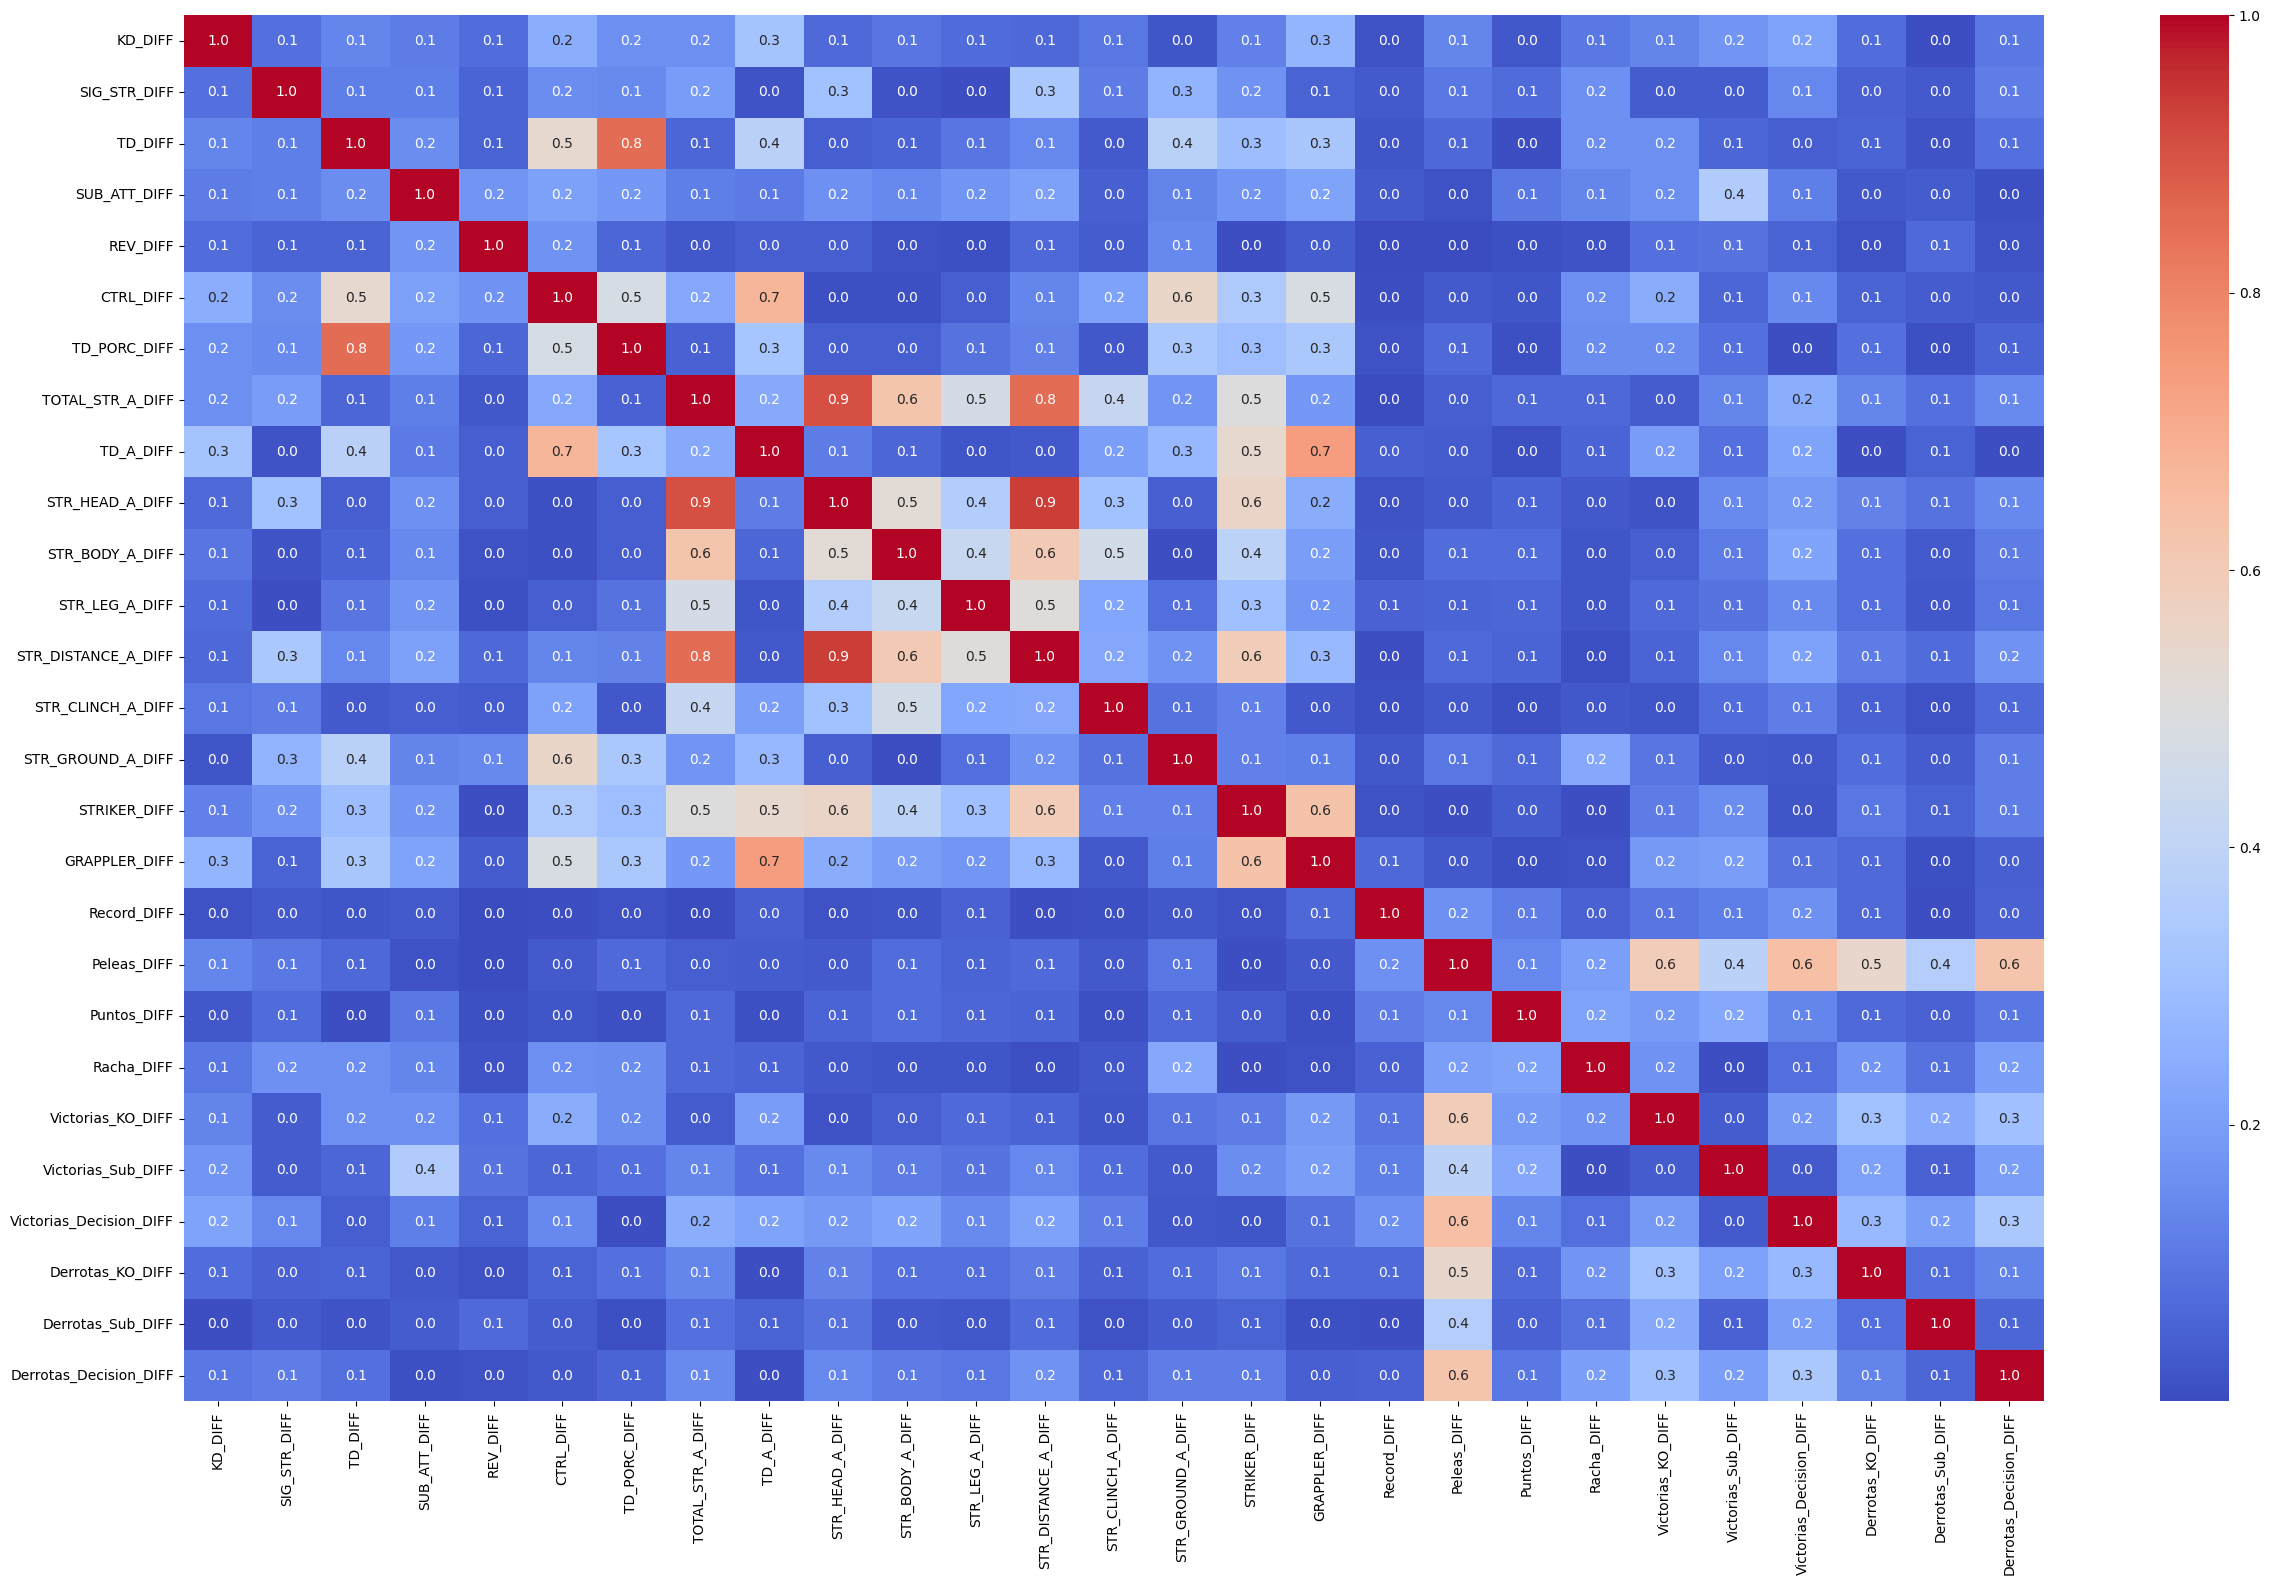

In [12]:
plt.figure(figsize=(30, 18))
sns.heatmap(X_train.corr(method="spearman").abs(), annot=True, cmap="coolwarm", fmt=".1f")
plt.show()

## Identificación de variables altamente correlacionadas

Se observa que hay algunas variables que están altamante correlacionadas. Este puede afectar de forma negativa al modelo, por lo que serán eliminadas.

In [13]:
correlation_matrix = X_train.corr(method='spearman')

umbral = 0.8
#Obtengo pares de variables con alta correlación (excluyendo la diagonal)
correlated_features = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

# Filtrar pares con correlación mayor al umbral
correlated_features.columns = ["Variable 1", "Variable 2", "Correlación"]
highly_correlated = correlated_features[abs(correlated_features["Correlación"]) > umbral]

# Mostrar todas las filas
pd.set_option('display.max_rows', None)
print("Variables altamente correlacionadas:\n", highly_correlated)

Variables altamente correlacionadas:
            Variable 1           Variable 2  Correlación
54            TD_DIFF         TD_PORC_DIFF     0.847866
162  TOTAL_STR_A_DIFF      STR_HEAD_A_DIFF     0.903239
165  TOTAL_STR_A_DIFF  STR_DISTANCE_A_DIFF     0.848549
200   STR_HEAD_A_DIFF  STR_DISTANCE_A_DIFF     0.935104


## Eliminación de variables altamente correlacionadas

Tras calcular la matriz de correlación de Spearman y detectar pares de variables con una **correlación absoluta mayor a 0.8**, son eliminadas algunas de ellas.

In [14]:
correlacionadas=['TD_PORC_DIFF','TOTAL_STR_A_DIFF', "STR_DISTANCE_A_DIFF"]

In [15]:
train_x2=X_train.drop(columns=correlacionadas)
test_x2=X_test.drop(columns=correlacionadas)

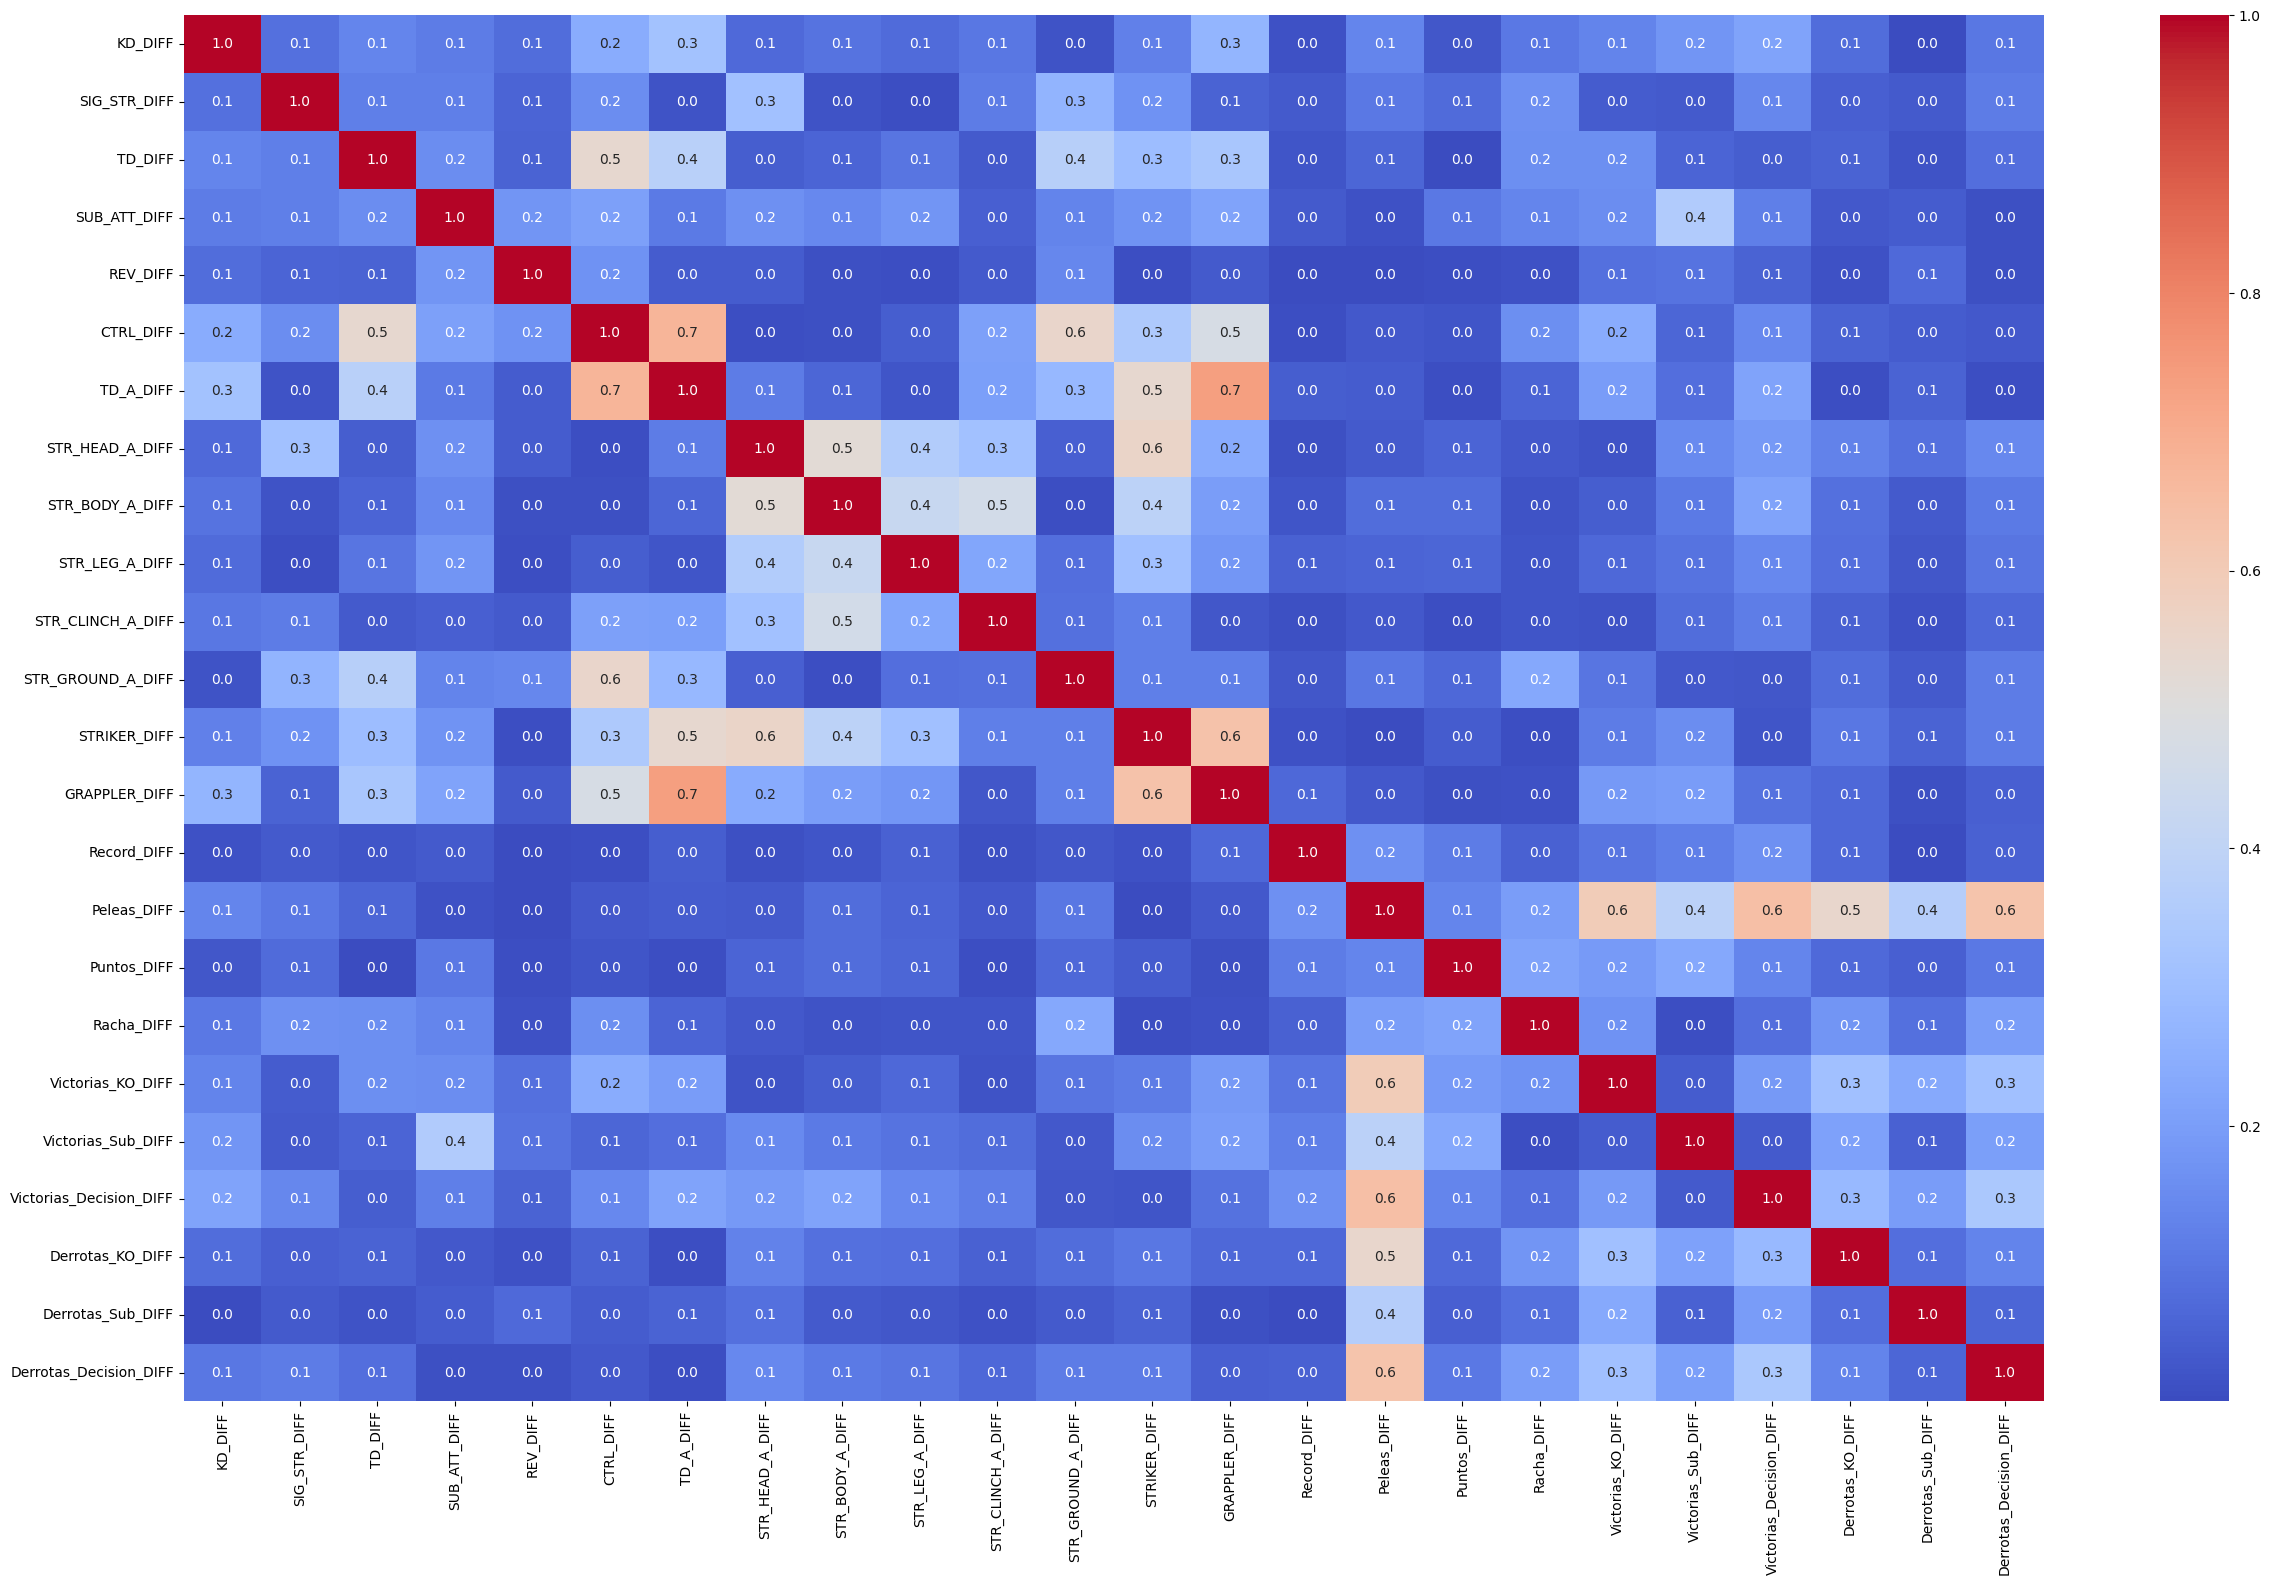

In [16]:
#Despues de eliminar correlaciones
plt.figure(figsize=(30, 18))
sns.heatmap(train_x2.corr(method="spearman").abs(), annot=True, cmap="coolwarm", fmt=".1f")
plt.show()

Se observa que ya no hay variables con una correlación mayor a 0.8.

## Escalado de variables

Para tratar de mejorar la precisión del modelo aplicamos un escalado a las variables.

In [17]:
scaler = RobustScaler()
train_x3 = scaler.fit_transform(train_x2)
test_x3 = scaler.transform(test_x2)

## Conversión de arrays escalados a DataFrames

Tras escalar los datos con `RobustScaler`, los resultados (`train_x3` y `test_x3`) son arrays de NumPy. Para facilitar su análisis y mantener la trazabilidad de las variables se convierten nuevamente en DataFrames (`train_x3_df` y `test_x3_df`)

In [18]:
train_x3_df = pd.DataFrame(train_x3,columns=train_x2.columns)
test_x3_df = pd.DataFrame(test_x3,columns=test_x2.columns)

## Ajuste de hiperparametros

### Función para realizar Grid Search con validación cruzada

Aplicamos GridSearch para tratar de encontrar el mejor modelo ajustando los hiperparámetros.

In [19]:

f1_scorer = make_scorer(f1_score, average='weighted')

def realizarGridSearchCV(estimador, param, X, Y):
    """Realiza la estrategia de búsqueda Grid Search CV"""

    kf = TimeSeriesSplit(n_splits=5)  
    grid_search = GridSearchCV(estimator=estimador, param_grid=param, cv=kf,
                            scoring=f1_scorer, refit = "f1_weighted", return_train_score=True, n_jobs=-1, error_score="raise")

    grid_search.fit(X, Y)
    
    return grid_search

## Función para realizar Randomized Search con validación cruzada

Se define la función `realizarRandomizedSearchCV()` para ejecutar una **búsqueda aleatoria de hiperparámetros** utilizando `RandomizedSearchCV`.

In [20]:
def realizarRandomizedSearchCV(estimador, param, X, Y):
    """Realiza la estrategia de búsqueda Grid Search CV"""
    kf = TimeSeriesSplit(n_splits=5)
    randomized_search = RandomizedSearchCV(estimator=estimador, param_distributions=param, cv=kf,
                            scoring=f1_scorer, refit = "f1_weighted", return_train_score=True, n_jobs=-1, error_score="raise")

    randomized_search.fit(X, Y)
    
    return randomized_search

## Entrenamiento de los modelos

In [21]:
# Cuadrícula de hiperparámetros
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'class_weight': [None, 'balanced', class_weight_dict],
    'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

param_distributions = {
    'C': loguniform(1e-4, 1e4),  # distribución logarítmica entre 0.0001 y 10000
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'class_weight': [None, 'balanced', class_weight_dict],
    'l1_ratio': uniform(0.0, 1.0)  # continuo entre 0 y 1
}

modelo = LogisticRegression(random_state=42, max_iter=500)

grid_search = realizarGridSearchCV(modelo, param_grid, train_x3, y_train)

modelo_final_grid = grid_search.best_estimator_
cv_results_grid = grid_search.cv_results_
best_params_grid = grid_search.best_params_


random_search = realizarRandomizedSearchCV(modelo, param_distributions, train_x3, y_train)

modelo_final_random = random_search.best_estimator_
cv_results_random = random_search.cv_results_
best_params_random = random_search.best_params_


c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [26]:
y_test_pred = modelo_final_grid.predict(test_x3)
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="GridSearchCV"):

    # Guardar modelo en MLflow
    mlflow.log_param("mejores_parametros", best_params_grid)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_test_pred))
    mlflow.log_metric("f1_macro", f1_score(y_test,y_test_pred))

    print("Modelo guardado en MLflow")

Modelo guardado en MLflow


In [28]:
y_test_pred = modelo_final_random.predict(test_x3)
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="RandomSearchCV"):

    # Guardar modelo en MLflow
    mlflow.log_param("mejores_parametros", best_params_random)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_test_pred))
    mlflow.log_metric("f1_macro", f1_score(y_test,y_test_pred))

    print("Modelo guardado en MLflow")

Modelo guardado en MLflow


## Evaluacion del modelo
Se crea un función que será la encargada de evaluar el modelo.

In [22]:
def evaluarModelo(modelo,test_x,test_y):
    """Predice a partir deun modelo y evalua el rendimiento del modelo mediante distintas métricas"""
    # Predicciones
    pred_y = modelo.predict(test_x)              # Predicción de clases
    prob_y = modelo.predict_proba(test_x)[:, 1]  # Probabilidad de la clase positiva

    # Cálculo de métricas
    accuracy = accuracy_score(test_y, pred_y)
    f1_val = f1_score(test_y, pred_y)
    roc_auc_val = roc_auc_score(test_y, prob_y)
    precision_val = precision_score(test_y, pred_y)
    recall_val = recall_score(test_y, pred_y)
    log_loss_val = log_loss(test_y, prob_y)

    # Imprimir métricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1_val:.4f}")
    print(f"AUC-ROC: {roc_auc_val:.4f}")
    print(f"Precisión: {precision_val:.4f}")
    print(f"Sensibilidad (Recall): {recall_val:.4f}")
    print(f"Log-loss: {log_loss_val:.4f}")
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(test_y, pred_y)

    # Visualizar la matriz de confusión
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

### Evaluación GridSearch

El modelo con hiperparámetros ajustados mediante GridSearchCV muestra un rendimiento moderado, con un accuracy de 0.58 y un F1-Score de 0.55, lo que indica un balance razonable entre precisión y recall. Sin embargo, la AUC-ROC de 0.62 sugiere que el modelo tiene un rendimiento limitado en la discriminación entre clases. Aunque la sensibilidad es relativamente alta, el log-loss de 0.67 indica que el modelo podría mejorar en cuanto a la precisión de sus probabilidades.


-- Métricas del modelo con hiperparámetros ajustados mediante GridSearchCV --
Accuracy: 0.5837
F1-Score: 0.5567
AUC-ROC: 0.6236
Precisión: 0.5387
Sensibilidad (Recall): 0.5759
Log-loss: 0.6719


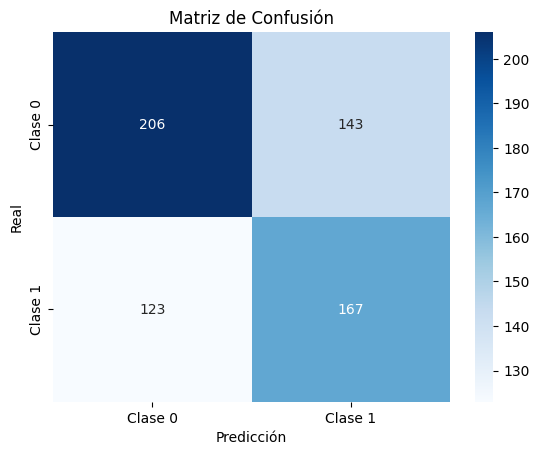

In [23]:
print("\n-- Métricas del modelo con hiperparámetros ajustados mediante GridSearchCV --")
evaluarModelo(modelo_final_grid,test_x3,y_test)       #Con 41 variables (rfecv.n_features_)

## Evaluación RandomizedSearchCV

El modelo es muy similar al anterior, aunque si que tiene un desempeño algo mayor.


-- Métricas del modelo con hiperparámetros ajustados mediante RandomizedSearchCV --
Accuracy: 0.5853
F1-Score: 0.5576
AUC-ROC: 0.6239
Precisión: 0.5405
Sensibilidad (Recall): 0.5759
Log-loss: 0.6719


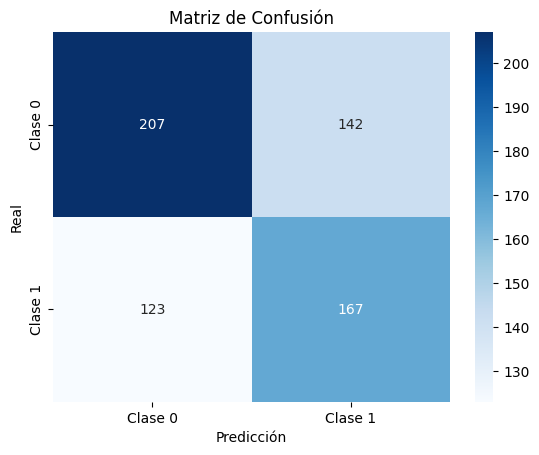

In [24]:
print("\n-- Métricas del modelo con hiperparámetros ajustados mediante RandomizedSearchCV --")
evaluarModelo(modelo_final_random,test_x3,y_test)    

## Conclusión
Ambos modelos presentan resultados modestos en cuanto a predicción, lo que indica que su rendimiento aún no es óptimo. Será necesario explorar otras técnicas o probar enfoques diferentes para mejorar la precisión y la capacidad de discriminación entre las clases.